In [3]:
pip install folium

     |████████████████████████████████| 93 kB 2.9 MB/s eta 0:00:011
Note: you may need to restart the kernel to use updated packages.


In [1]:
import numpy as np
import pandas as pd

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json

from geopy.geocoders import Nominatim

import requests
from pandas.io.json import json_normalize

import matplotlib.cm as cm
import matplotlib.colors as colors

from sklearn.cluster import KMeans

import folium 

## 1. Download and Explore DataSet

In [2]:
!wget -q -O 'newyork_data.json' https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DS0701EN-SkillsNetwork/labs/newyork_data.json
print('Data downloaded!')

Data downloaded!


In [4]:
with open('newyork_data.json') as json_data:
    newyork_data = json.load(json_data)

newyork_data

{'type': 'FeatureCollection',
 'totalFeatures': 306,
 'features': [{'type': 'Feature',
   'id': 'nyu_2451_34572.1',
   'geometry': {'type': 'Point',
    'coordinates': [-73.84720052054902, 40.89470517661]},
   'geometry_name': 'geom',
   'properties': {'name': 'Wakefield',
    'stacked': 1,
    'annoline1': 'Wakefield',
    'annoline2': None,
    'annoline3': None,
    'annoangle': 0.0,
    'borough': 'Bronx',
    'bbox': [-73.84720052054902,
     40.89470517661,
     -73.84720052054902,
     40.89470517661]}},
  {'type': 'Feature',
   'id': 'nyu_2451_34572.2',
   'geometry': {'type': 'Point',
    'coordinates': [-73.82993910812398, 40.87429419303012]},
   'geometry_name': 'geom',
   'properties': {'name': 'Co-op City',
    'stacked': 2,
    'annoline1': 'Co-op',
    'annoline2': 'City',
    'annoline3': None,
    'annoangle': 0.0,
    'borough': 'Bronx',
    'bbox': [-73.82993910812398,
     40.87429419303012,
     -73.82993910812398,
     40.87429419303012]}},
  {'type': 'Feature',
 

In [6]:
neighborhoods_data = newyork_data['features']

neighborhoods_data[0]

{'type': 'Feature',
 'id': 'nyu_2451_34572.1',
 'geometry': {'type': 'Point',
  'coordinates': [-73.84720052054902, 40.89470517661]},
 'geometry_name': 'geom',
 'properties': {'name': 'Wakefield',
  'stacked': 1,
  'annoline1': 'Wakefield',
  'annoline2': None,
  'annoline3': None,
  'annoangle': 0.0,
  'borough': 'Bronx',
  'bbox': [-73.84720052054902,
   40.89470517661,
   -73.84720052054902,
   40.89470517661]}}

In [10]:
column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 

neighborhoods = pd.DataFrame(columns=column_names)

for data in neighborhoods_data:
    borough = neighborhood_name = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
        
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    neighborhoods = neighborhoods.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)

neighborhoods.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


In [11]:
print('The dataframe has {} boroughs and {} neighborhoods.'.format(
        len(neighborhoods['Borough'].unique()),
        neighborhoods.shape[0]
    )
)

The dataframe has 5 boroughs and 306 neighborhoods.


In [12]:
manhattan_data = neighborhoods[neighborhoods['Borough'] == 'Manhattan'].reset_index(drop=True)
manhattan_data.head()

,Borough,Neighborhood,Latitude,Longitude
0,Manhattan,Marble Hill,40.876551,-73.910660
1,Manhattan,Chinatown,40.715618,-73.994279
2,Manhattan,Washington Heights,40.851903,-73.936900
3,Manhattan,Inwood,40.867684,-73.921210
4,Manhattan,Hamilton Heights,40.823604,-73.949688


In [13]:
address = 'Manhattan, NY'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Manhattan are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Manhattan are 40.7896239, -73.9598939.


## 2. Map of Manhattan

In [14]:
map_manhattan = folium.Map(location=[latitude, longitude], zoom_start=11)

for lat, lng, label in zip(manhattan_data['Latitude'], manhattan_data['Longitude'], manhattan_data['Neighborhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_manhattan)  
    
map_manhattan

In [15]:
CLIENT_ID = 'JLZQPXTOTDNY04KVADLUM4UP1IIUKDZAX1Y2JUP3APW2HBJM'
CLIENT_SECRET = '3OFXG5MX5Y5QYSOFFFQMWXRKSHJFHLR0OZGKQQVYADD2GRB5'
VERSION = '20201020'
LIMIT = 100

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: JLZQPXTOTDNY04KVADLUM4UP1IIUKDZAX1Y2JUP3APW2HBJM
CLIENT_SECRET:3OFXG5MX5Y5QYSOFFFQMWXRKSHJFHLR0OZGKQQVYADD2GRB5


## 3. Explore Neighbourhoods in Manhattan

In [17]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [18]:
manhattan_venues = getNearbyVenues(names=manhattan_data['Neighborhood'],
                                   latitudes=manhattan_data['Latitude'],
                                   longitudes=manhattan_data['Longitude']
                                  )

Marble Hill
Chinatown
Washington Heights
Inwood
Hamilton Heights
Manhattanville
Central Harlem
East Harlem
Upper East Side
Yorkville
Lenox Hill
Roosevelt Island
Upper West Side
Lincoln Square
Clinton
Midtown
Murray Hill
Chelsea
Greenwich Village
East Village
Lower East Side
Tribeca
Little Italy
Soho
West Village
Manhattan Valley
Morningside Heights
Gramercy
Battery Park City
Financial District
Carnegie Hill
Noho
Civic Center
Midtown South
Sutton Place
Turtle Bay
Tudor City
Stuyvesant Town
Flatiron
Hudson Yards


In [19]:
print(manhattan_venues.shape)
manhattan_venues.head()

(3212, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Marble Hill,40.876551,-73.91066,Bikram Yoga,40.876844,-73.906204,Yoga Studio
1,Marble Hill,40.876551,-73.91066,Arturo's,40.874412,-73.910271,Pizza Place
2,Marble Hill,40.876551,-73.91066,Tibbett Diner,40.880404,-73.908937,Diner
3,Marble Hill,40.876551,-73.91066,Starbucks,40.877531,-73.905582,Coffee Shop
4,Marble Hill,40.876551,-73.91066,Dunkin',40.877136,-73.906666,Donut Shop


In [20]:
manhattan_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Battery Park City,66,66,66,66,66,66
Carnegie Hill,89,89,89,89,89,89
Central Harlem,45,45,45,45,45,45
Chelsea,100,100,100,100,100,100
Chinatown,100,100,100,100,100,100
Civic Center,100,100,100,100,100,100
Clinton,100,100,100,100,100,100
East Harlem,40,40,40,40,40,40
East Village,100,100,100,100,100,100


In [21]:
print('There are {} uniques categories.'.format(len(manhattan_venues['Venue Category'].unique())))

There are 321 uniques categories.


## 4. Analyse each Neighbourhood

In [23]:
manhattan_onehot = pd.get_dummies(manhattan_venues[['Venue Category']], prefix="", prefix_sep="")

manhattan_onehot['Neighborhood'] = manhattan_venues['Neighborhood'] 

fixed_columns = [manhattan_onehot.columns[-1]] + list(manhattan_onehot.columns[:-1])
manhattan_onehot = manhattan_onehot[fixed_columns]

manhattan_onehot.head()

,Neighborhood,Accessories Store,Adult Boutique,African Restaurant,American Restaurant,Antique Shop,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auditorium,Australian Restaurant,Austrian Restaurant,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Basketball Court,Beer Bar,Beer Garden,Beer Store,Bike Rental / Bike Share,Bike Shop,Bike Trail,Bistro,Board Shop,Boat or Ferry,Bookstore,Boutique,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Bridal Shop,Bridge,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Station,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Camera Store,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Check Cashing Service,Cheese Shop,Chinese Restaurant,Chocolate Shop,Circus,Climbing Gym,Clothing Store,Club House,Cocktail Bar,Coffee Shop,College Academic Building,College Arts Building,College Bookstore,College Cafeteria,College Theater,Comedy Club,Community Center,Concert Hall,Convenience Store,Cooking School,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Cycle Studio,Czech Restaurant,Dance Studio,Daycare,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dive Bar,Doctor's Office,Dog Run,Donut Shop,Drugstore,Dry Cleaner,Dumpling Restaurant,Duty-free Shop,Eastern European Restaurant,Electronics Store,Empanada Restaurant,Ethiopian Restaurant,Event Space,Exhibit,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish Market,Flea Market,Flower Shop,Food & Drink Shop,Food Court,Food Stand,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Heliport,High School,Himalayan Restaurant,Historic Site,History Museum,Hobby Shop,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotpot Restaurant,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Irish Pub,Israeli Restaurant,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Kebab Restaurant,Kids Store,Kitchen Supply Store,Korean Restaurant,Kosher Restaurant,Latin American Restaurant,Laundry Service,Leather Goods Store,Lebanese Restaurant,Library,Lingerie Store,Liquor Store,Lounge,Malay Restaurant,Market,Martial Arts School,Massage Studio,Mattress Store,Medical Center,Mediterranean Restaurant,Memorial Site,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Movie Theater,Moving Target,Museum,Music School,Music Venue,Nail Salon,New American Restaurant,Newsstand,Nightclub,Non-Profit,Noodle House,North Indian Restaurant,Office,Opera House,Optical Shop,Organic Grocery,Outdoor Sculpture,Outdoors & Recreation,Paella Restaurant,Paper / Office Supplies Store,Park,Pedestrian Plaza,Performing Arts Venue,Persian Restaurant,Peruvian Restaurant,Pet Café,Pet Service,Pet Store,Pharmacy,Photography Studio,Piano Bar,Pie Shop,Pier,Pilates Studio,Pizza Place,Playground,Plaza,Poke Place,Pool,Pub,Public Art,Ramen Restaurant,Record Shop,Rental Car Location,Residential Building (Apartment / Condo),Resort,Rest Area,Restaurant,River,Rock Club,Roof Deck,Russian Restaurant,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scandinavian Restaurant,Scenic Lookout,School,Sculpture Garden,Seafood Restaurant,Shanghai Restaurant,Shipping Store,Shoe Store,Shopping Mall,Skate Park,Smoke Shop,Smoothie Shop,Snack Place,Soba Restaurant,Soccer Field,Social Club,Soup Place,South American Restaurant,South Indian Restaurant,Southern / Soul Foo

In [24]:
manhattan_onehot.shape

(3212, 322)

In [28]:
manhattan_grouped = manhattan_onehot.groupby('Neighborhood').mean().reset_index()
manhattan_grouped

,Neighborhood,Accessories Store,Adult Boutique,African Restaurant,American Restaurant,Antique Shop,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auditorium,Australian Restaurant,Austrian Restaurant,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Basketball Court,Beer Bar,Beer Garden,Beer Store,Bike Rental / Bike Share,Bike Shop,Bike Trail,Bistro,Board Shop,Boat or Ferry,Bookstore,Boutique,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Bridal Shop,Bridge,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Station,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Camera Store,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Check Cashing Service,Cheese Shop,Chinese Restaurant,Chocolate Shop,Circus,Climbing Gym,Clothing Store,Club House,Cocktail Bar,Coffee Shop,College Academic Building,College Arts Building,College Bookstore,College Cafeteria,College Theater,Comedy Club,Community Center,Concert Hall,Convenience Store,Cooking School,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Cycle Studio,Czech Restaurant,Dance Studio,Daycare,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dive Bar,Doctor's Office,Dog Run,Donut Shop,Drugstore,Dry Cleaner,Dumpling Restaurant,Duty-free Shop,Eastern European Restaurant,Electronics Store,Empanada Restaurant,Ethiopian Restaurant,Event Space,Exhibit,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish Market,Flea Market,Flower Shop,Food & Drink Shop,Food Court,Food Stand,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Heliport,High School,Himalayan Restaurant,Historic Site,History Museum,Hobby Shop,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotpot Restaurant,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Irish Pub,Israeli Restaurant,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Kebab Restaurant,Kids Store,Kitchen Supply Store,Korean Restaurant,Kosher Restaurant,Latin American Restaurant,Laundry Service,Leather Goods Store,Lebanese Restaurant,Library,Lingerie Store,Liquor Store,Lounge,Malay Restaurant,Market,Martial Arts School,Massage Studio,Mattress Store,Medical Center,Mediterranean Restaurant,Memorial Site,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Movie Theater,Moving Target,Museum,Music School,Music Venue,Nail Salon,New American Restaurant,Newsstand,Nightclub,Non-Profit,Noodle House,North Indian Restaurant,Office,Opera House,Optical Shop,Organic Grocery,Outdoor Sculpture,Outdoors & Recreation,Paella Restaurant,Paper / Office Supplies Store,Park,Pedestrian Plaza,Performing Arts Venue,Persian Restaurant,Peruvian Restaurant,Pet Café,Pet Service,Pet Store,Pharmacy,Photography Studio,Piano Bar,Pie Shop,Pier,Pilates Studio,Pizza Place,Playground,Plaza,Poke Place,Pool,Pub,Public Art,Ramen Restaurant,Record Shop,Rental Car Location,Residential Building (Apartment / Condo),Resort,Rest Area,Restaurant,River,Rock Club,Roof Deck,Russian Restaurant,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scandinavian Restaurant,Scenic Lookout,School,Sculpture Garden,Seafood Restaurant,Shanghai Restaurant,Shipping Store,Shoe Store,Shopping Mall,Skate Park,Smoke Shop,Smoothie Shop,Snack Place,Soba Restaurant,Soccer Field,Social Club,Soup Place,South American Restaurant,South Indian Restaurant,Southern / Soul Foo

In [29]:
manhattan_grouped.shape

(40, 322)

In [30]:
num_top_venues = 5

for hood in manhattan_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = manhattan_grouped[manhattan_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Battery Park City----
           venue  freq
0           Park  0.09
1          Hotel  0.08
2            Gym  0.06
3    Coffee Shop  0.06
4  Memorial Site  0.05


----Carnegie Hill----
         venue  freq
0  Coffee Shop  0.09
1         Café  0.04
2  Yoga Studio  0.03
3    Wine Shop  0.03
4  Pizza Place  0.03


----Central Harlem----
                 venue  freq
0   African Restaurant  0.07
1   Seafood Restaurant  0.04
2    French Restaurant  0.04
3  American Restaurant  0.04
4                  Bar  0.04


----Chelsea----
                 venue  freq
0          Coffee Shop  0.10
1          Art Gallery  0.05
2  American Restaurant  0.04
3               Bakery  0.04
4   Italian Restaurant  0.03


----Chinatown----
                 venue  freq
0   Chinese Restaurant  0.09
1               Bakery  0.06
2         Cocktail Bar  0.05
3         Dessert Shop  0.04
4  American Restaurant  0.04


----Civic Center----
                  venue  freq
0           Coffee Shop  0.05
1                 

In [32]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [40]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = manhattan_grouped['Neighborhood']

for ind in np.arange(manhattan_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(manhattan_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Battery Park City,Park,Hotel,Coffee Shop,Gym,Memorial Site,Shopping Mall,Food Court,Clothing Store,Gourmet Shop,Boat or Ferry
1,Carnegie Hill,Coffee Shop,Café,Yoga Studio,Wine Shop,Italian Restaurant,Gym / Fitness Center,Gym,French Restaurant,Pizza Place,Bookstore
2,Central Harlem,African Restaurant,Cosmetics Shop,French Restaurant,American Restaurant,Bar,Seafood Restaurant,Chinese Restaurant,Salon / Barbershop,Coffee Shop,Cocktail Bar
3,Chelsea,Coffee Shop,Art Gallery,Bakery,American Restaurant,Italian Restaurant,Ice Cream Shop,Cycle Studio,Cupcake Shop,Café,Market
4,Chinatown,Chinese Restaurant,Bakery,Cocktail Bar,American Restaurant,Dessert Shop,Noodle House,Salon / Barbershop,Optical Shop,Spa,Hotpot Restaurant


## 5. Cluster Neighbourhoods

In [41]:
kclusters = 5

manhattan_grouped_clustering = manhattan_grouped.drop('Neighborhood', 1)

kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(manhattan_grouped_clustering)

kmeans.labels_[0:10] 

array([1, 1, 1, 1, 1, 1, 1, 4, 1, 1], dtype=int32)

In [42]:
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

manhattan_merged = manhattan_data

manhattan_merged = manhattan_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

manhattan_merged

,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Manhattan,Marble Hill,40.876551,-73.910660,2,Sandwich Place,Coffee Shop,Gym,Discount Store,Supplement Shop,Donut Shop,Seafood Restaurant,Tennis Stadium,Pharmacy,Kids Store
1,Manhattan,Chinatown,40.715618,-73.994279,1,Chinese Restaurant,Bakery,Cocktail Bar,American Restaurant,Dessert Shop,Noodle House,Salon / Barbershop,Optical Shop,Spa,Hotpot Restaurant
2,Manhattan,Washington Heights,40.851903,-73.936900,4,Café,Bakery,Mobile Phone Shop,Grocery Store,Deli / Bodega,Coffee Shop,Spanish Restaurant,Supermarket,Supplement Shop,Tapas Restaurant
3,Manhattan,Inwood,40.867684,-73.921210,4,Mexican Restaurant,Café,Restaurant,Lounge,Frozen Yogurt Shop,Bakery,Pizza Place,Park,Chinese Restaurant,Deli / Bodega
4,Manhattan,Hamilton Heights,40.823604,-73.949688,4,Pizza Place,Coffee Shop,Café,Mexican Restaurant,Yoga Studio,Bakery,Latin American Restaurant,Liquor Store,Park,Deli / Bodega
5,Manhattan,Manhattanville,40.816934,-73.957385,4,Seafood Restaurant,Coffee Shop,Deli / Bodega,Italian Restaurant,Mexican Restaurant,Indian Restaurant,Lounge,Boutique,Sushi Restaurant,Supermarket
6,Manhattan,Central Harlem,40.815976,-73.943211,1,African Restaurant,Cosmetics Shop,French Restaurant,American Restaurant,Bar,Seafood Restaurant,Chinese Restaurant,Salon / Barbershop,Coffee Shop,Cocktail Bar
7,Manhattan,East Harlem,40.792249,-73.944182,4,Mexican Restaurant,Bakery,Thai Restaurant,Deli / Bodega,Sandwich Place,Latin American Restaurant,French Restaurant,Gym,Grocery Store,Taco Place
8,Manhattan,Upper East Side,40.775639,-73.960508,0,Italian Restaurant,Exhibit,Coffee Shop,Bakery,Gym / Fitness Center,Yoga Studio,Juice Bar,Hotel,French Restaurant,Cosmetics Shop
9,Manhattan,Yorkville,40.775930,-73.947118,1,Italian Restaurant,Bar,Gym,Coffee Shop,Sushi Restaurant,Deli / Bodega,Wine Shop,Diner,Japanese Restaurant,Mexican Restaurant


In [47]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(manhattan_merged['Latitude'], manhattan_merged['Longitude'], manhattan_merged['Neighborhood'], manhattan_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [67]:
manhattan_merged.shape

(40, 15)

In [62]:
manhattan_merged.loc[manhattan_merged['Cluster Labels'] == 0, manhattan_merged.columns[[1] + list(range(5, manhattan_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
8,Upper East Side,Italian Restaurant,Exhibit,Coffee Shop,Bakery,Gym / Fitness Center,Yoga Studio,Juice Bar,Hotel,French Restaurant,Cosmetics Shop
13,Lincoln Square,Plaza,Italian Restaurant,Concert Hall,Performing Arts Venue,Café,Theater,Bakery,Indie Movie Theater,French Restaurant,Wine Shop
18,Greenwich Village,Italian Restaurant,Sushi Restaurant,Clothing Store,Café,American Restaurant,Gym,Boutique,Bubble Tea Shop,Indian Restaurant,Chinese Restaurant
23,Soho,Italian Restaurant,Clothing Store,Coffee Shop,Boutique,Bakery,Shoe Store,Café,Mediterranean Restaurant,French Restaurant,Sporting Goods Shop
24,West Village,Italian Restaurant,American Restaurant,New American Restaurant,Cocktail Bar,Wine Bar,Park,Jazz Club,Pizza Place,Coffee Shop,Theater


In [63]:
manhattan_merged.loc[manhattan_merged['Cluster Labels'] == 1, manhattan_merged.columns[[1] + list(range(5, manhattan_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,Chinatown,Chinese Restaurant,Bakery,Cocktail Bar,American Restaurant,Dessert Shop,Noodle House,Salon / Barbershop,Optical Shop,Spa,Hotpot Restaurant
6,Central Harlem,African Restaurant,Cosmetics Shop,French Restaurant,American Restaurant,Bar,Seafood Restaurant,Chinese Restaurant,Salon / Barbershop,Coffee Shop,Cocktail Bar
9,Yorkville,Italian Restaurant,Bar,Gym,Coffee Shop,Sushi Restaurant,Deli / Bodega,Wine Shop,Diner,Japanese Restaurant,Mexican Restaurant
10,Lenox Hill,Italian Restaurant,Sushi Restaurant,Coffee Shop,Pizza Place,Cocktail Bar,Café,Gym,Gym / Fitness Center,Burger Joint,Playground
11,Roosevelt Island,Deli / Bodega,Plaza,Coffee Shop,Sandwich Place,Gym / Fitness Center,Gym,Dry Cleaner,Greek Restaurant,School,Outdoors & Recreation
12,Upper West Side,Italian Restaurant,Bar,Café,Wine Bar,Indian Restaurant,Bakery,Pizza Place,Coffee Shop,Vegetarian / Vegan Restaurant,Mediterranean Restaurant
14,Clinton,Theater,American Restaurant,Gym / Fitness Center,Coffee Shop,Cocktail Bar,Gym,Spa,Sandwich Place,Hotel,Italian Restaurant
15,Midtown,Hotel,Bakery,Clothing Store,Coffee Shop,Theater,Steakhouse,Bookstore,Café,Sporting Goods Shop,Sushi Restaurant
16,Murray Hill,Japanese Restaurant,American Restaurant,Gym / Fitness Center,Sandwich Place,Hotel,Coffee Shop,Italian Restaurant,Bar,Restaurant,Grocery Store
17,Chelsea,Coffee Shop,Art Gallery,Bakery,American Restaurant,Italian Restaurant,Ice Cream Shop,Cycle Studio,Cupcake Shop,Café,Market


In [64]:
manhattan_merged.loc[manhattan_merged['Cluster Labels'] == 2, manhattan_merged.columns[[1] + list(range(5, manhattan_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Marble Hill,Sandwich Place,Coffee Shop,Gym,Discount Store,Supplement Shop,Donut Shop,Seafood Restaurant,Tennis Stadium,Pharmacy,Kids Store


In [65]:
manhattan_merged.loc[manhattan_merged['Cluster Labels'] == 3, manhattan_merged.columns[[1] + list(range(5, manhattan_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
37,Stuyvesant Town,Park,Harbor / Marina,Cocktail Bar,Baseball Field,Bar,Gym / Fitness Center,Heliport,Bistro,Farmers Market,Boat or Ferry


In [66]:
manhattan_merged.loc[manhattan_merged['Cluster Labels'] == 4, manhattan_merged.columns[[1] + list(range(5, manhattan_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
2,Washington Heights,Café,Bakery,Mobile Phone Shop,Grocery Store,Deli / Bodega,Coffee Shop,Spanish Restaurant,Supermarket,Supplement Shop,Tapas Restaurant
3,Inwood,Mexican Restaurant,Café,Restaurant,Lounge,Frozen Yogurt Shop,Bakery,Pizza Place,Park,Chinese Restaurant,Deli / Bodega
4,Hamilton Heights,Pizza Place,Coffee Shop,Café,Mexican Restaurant,Yoga Studio,Bakery,Latin American Restaurant,Liquor Store,Park,Deli / Bodega
5,Manhattanville,Seafood Restaurant,Coffee Shop,Deli / Bodega,Italian Restaurant,Mexican Restaurant,Indian Restaurant,Lounge,Boutique,Sushi Restaurant,Supermarket
7,East Harlem,Mexican Restaurant,Bakery,Thai Restaurant,Deli / Bodega,Sandwich Place,Latin American Restaurant,French Restaurant,Gym,Grocery Store,Taco Place
26,Morningside Heights,Park,American Restaurant,Coffee Shop,Bookstore,Deli / Bodega,Burger Joint,Ice Cream Shop,Ethiopian Restaurant,Grocery Store,Tennis Court
36,Tudor City,Park,Café,Mexican Restaurant,Asian Restaurant,Deli / Bodega,Diner,Coffee Shop,Seafood Restaurant,Greek Restaurant,Gym


In [73]:
df0=manhattan_merged.loc[manhattan_merged['Cluster Labels'] == 0, manhattan_merged.columns[[1] + list(range(5, manhattan_merged.shape[1]))]]

df1=manhattan_merged.loc[manhattan_merged['Cluster Labels'] == 1, manhattan_merged.columns[[1] + list(range(5, manhattan_merged.shape[1]))]]

df2=manhattan_merged.loc[manhattan_merged['Cluster Labels'] == 2, manhattan_merged.columns[[1] + list(range(5, manhattan_merged.shape[1]))]]

df3=manhattan_merged.loc[manhattan_merged['Cluster Labels'] == 3, manhattan_merged.columns[[1] + list(range(5, manhattan_merged.shape[1]))]]

df4=manhattan_merged.loc[manhattan_merged['Cluster Labels'] == 4, manhattan_merged.columns[[1] + list(range(5, manhattan_merged.shape[1]))]]

In [111]:

body = client_9787906dae5c49b8b85b6f22916a0ef2.get_object(Bucket='finalcapstoneproject-donotdelete-pr-temgay5yp09ur1',Key='housing_price.csv')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

df_data_3 = pd.read_csv(body)
df_data_3.head()
body = client_9787906dae5c49b8b85b6f22916a0ef2.get_object(Bucket='finalcapstoneproject-donotdelete-pr-temgay5yp09ur1',Key='housing_price.csv')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

df_data_2 = pd.read_csv(body)
df_data_2.head()
import types
import pandas as pd
from botocore.client import Config
import ibm_boto3

def __iter__(self): return 0

# @hidden_cell
# The following code accesses a file in your IBM Cloud Object Storage. It includes your credentials.
# You might want to remove those credentials before you share the notebook.
client_9787906dae5c49b8b85b6f22916a0ef2 = ibm_boto3.client(service_name='s3',
    ibm_api_key_id='Lys4OrixBLHhQmptsSu19XoJy_iblbWkQJHnj5grBNf1',
    ibm_auth_endpoint="https://iam.cloud.ibm.com/oidc/token",
    config=Config(signature_version='oauth'),
    endpoint_url='https://s3.eu-geo.objectstorage.service.networklayer.com')

body = client_9787906dae5c49b8b85b6f22916a0ef2.get_object(Bucket='finalcapstoneproject-donotdelete-pr-temgay5yp09ur1',Key='housing_price.csv')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

df_data_1 = pd.read_csv(body)
df_data_1.head()

,Neighborhood,Average Housing Price( in $)
0,Marble Hill,1708.0
1,Washington Heights,2284.0
2,Inwood,2375.0
3,Randalls and Wards Islands,2394.0
4,Harlem,2948.0


In [112]:
Manhattan_Avg_HousingPrice=pd.DataFrame({"Neighborhood":df1["Neighborhood"]})
Manhattan_Avg_HousingPrice

,Neighborhood
1,Chinatown
6,Central Harlem
9,Yorkville
10,Lenox Hill
11,Roosevelt Island
12,Upper West Side
14,Clinton
15,Midtown
16,Murray Hill
17,Chelsea


In [116]:
Manhattan_Avg_HousingPrice=Manhattan_Avg_HousingPrice.merge(df_data_1, on='Neighborhood', how='left')

In [117]:
Manhattan_Avg_HousingPrice.set_index('Neighborhood',inplace=True,drop=True)

In [118]:
Manhattan_Avg_HousingPrice

,Average Housing Price( in $)
Neighborhood,
Chinatown,5116.0
Central Harlem,2965.0
Yorkville,4458.0
Lenox Hill,4231.0
Roosevelt Island,3416.0
Upper West Side,4668.0
Clinton,4053.0
Midtown,4022.0
Murray Hill,4143.0


In [120]:
Manhattan_Avg_HousingPrice.astype(float)

,Average Housing Price( in $)
Neighborhood,
Chinatown,5116.0
Central Harlem,2965.0
Yorkville,4458.0
Lenox Hill,4231.0
Roosevelt Island,3416.0
Upper West Side,4668.0
Clinton,4053.0
Midtown,4022.0
Murray Hill,4143.0


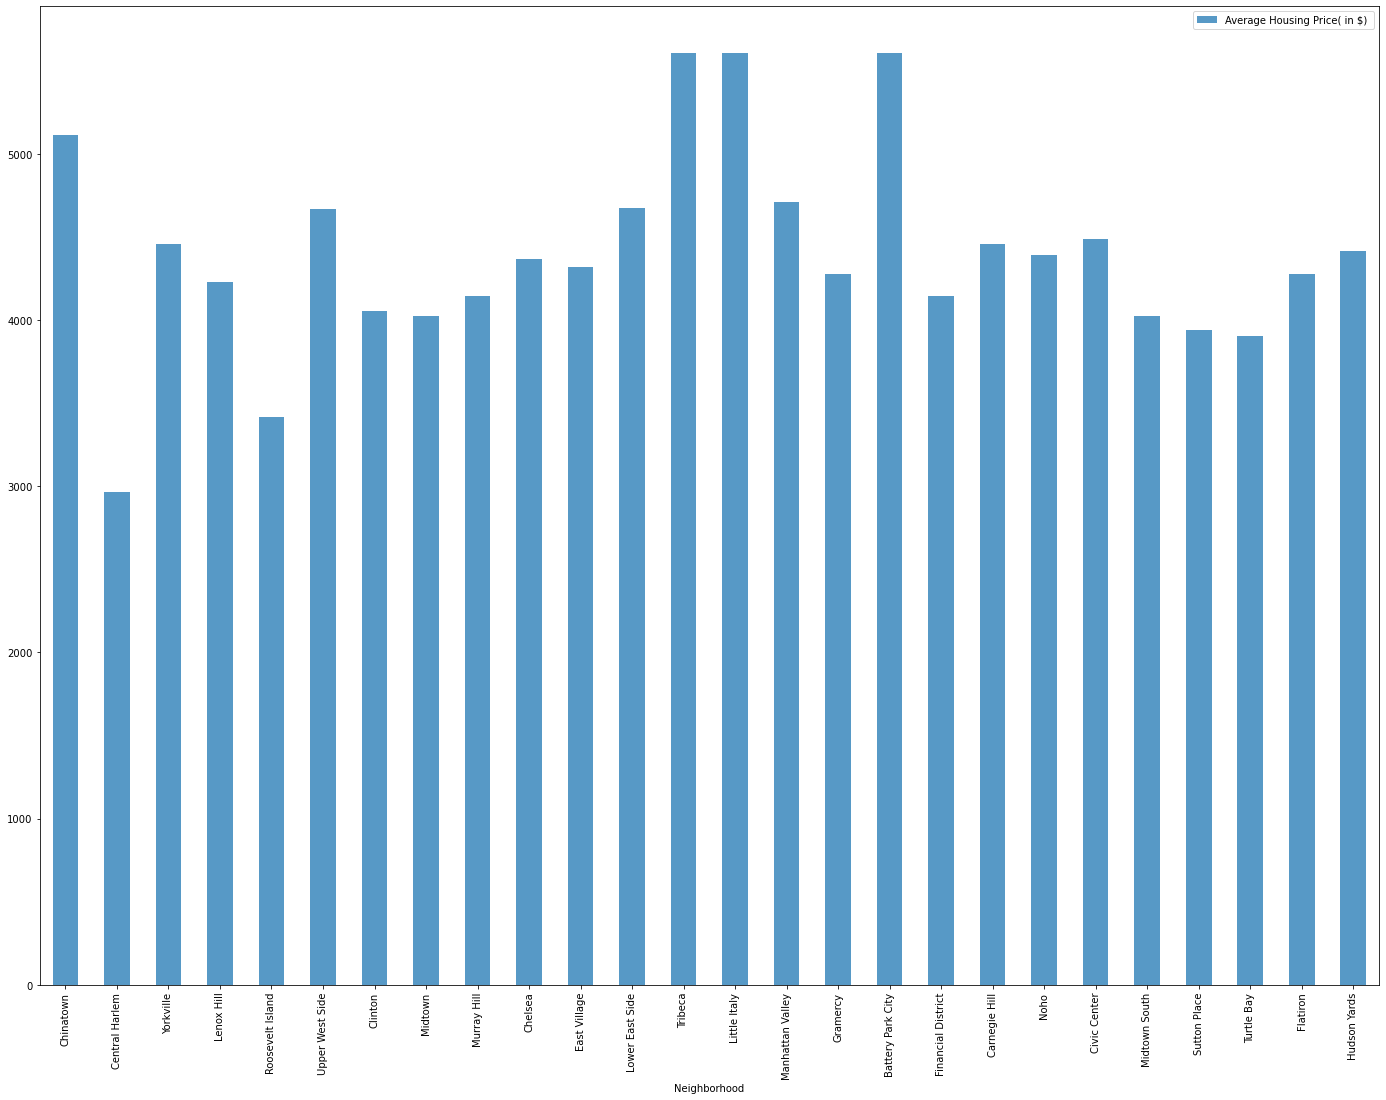

In [121]:
Manhattan_Avg_HousingPrice.plot(kind='bar',figsize=(24,18),alpha=0.75)

In [123]:

body = client_9787906dae5c49b8b85b6f22916a0ef2.get_object(Bucket='finalcapstoneproject-donotdelete-pr-temgay5yp09ur1',Key='school_rating.csv')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )
#Source : greatschools.org
df_data_4 = pd.read_csv(body)
df_data_4.head()

,Neighborhood,School Rating
0,Marble Hill,5
1,Washington Heights,6
2,Inwood,8
3,Randalls and Wards Islands,5
4,Harlem,5


In [131]:
Manhattan_School_Rating=pd.DataFrame({"Neighborhood":df1["Neighborhood"]})
Manhattan_School_Rating

,Neighborhood
1,Chinatown
6,Central Harlem
9,Yorkville
10,Lenox Hill
11,Roosevelt Island
12,Upper West Side
14,Clinton
15,Midtown
16,Murray Hill
17,Chelsea


In [132]:
Manhattan_School_Rating=Manhattan_School_Rating.merge(df_data_4, on='Neighborhood', how='left')
Manhattan_School_Rating.set_index('Neighborhood',inplace=True,drop=True)

In [133]:
Manhattan_School_Rating

,School Rating
Neighborhood,
Chinatown,9
Central Harlem,10
Yorkville,9
Lenox Hill,7
Roosevelt Island,8
Upper West Side,6
Clinton,7
Midtown,5
Murray Hill,6


In [134]:
Manhattan_School_Rating.astype(float)

,School Rating
Neighborhood,
Chinatown,9.0
Central Harlem,10.0
Yorkville,9.0
Lenox Hill,7.0
Roosevelt Island,8.0
Upper West Side,6.0
Clinton,7.0
Midtown,5.0
Murray Hill,6.0


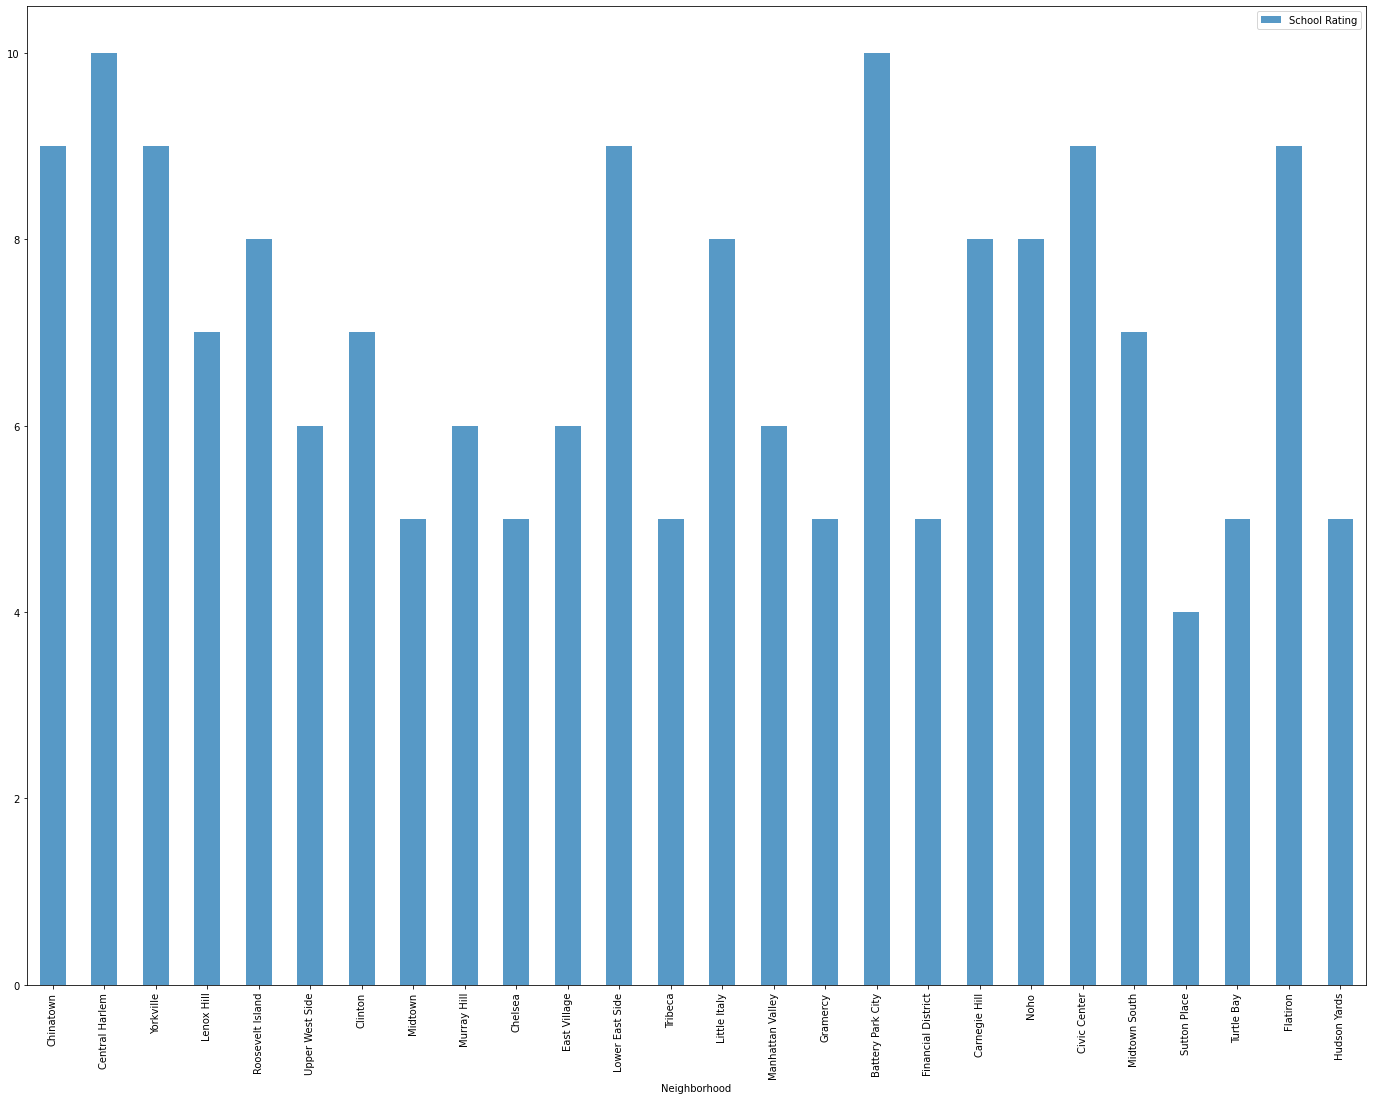

In [135]:
Manhattan_School_Rating.plot(kind='bar',figsize=(24,18),alpha=0.75)

### In this project using k-means, i identified 5 clusters.Then i picked a cluster and identified the average housing price and the schools ratings for the neighbourhoods present in that cluster. Similarly, this can be repeated for other clusters as well. 